<a href="https://colab.research.google.com/github/takuya-tokumoto/GDL_code/blob/master/colab_pytorch/3%E7%AB%A0_%E5%A4%89%E5%88%86%E3%82%AA%E3%83%BC%E3%83%88%E3%82%A8%E3%83%B3%E3%82%B3%E3%83%BC%E3%83%80_%E3%82%AA%E3%83%BC%E3%83%88%E3%82%A8%E3%83%B3%E3%82%B3%E3%83%BC%E3%83%80(%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF%E5%B1%A4%E3%81%AA%E3%81%97)ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

【README】  
- オートエンコーダを利用して、手書き文字データから新たな画像を生成
- 畳み込み層は利用せず全結合層(Linear)のみでのモデル構造で実装
- Pytorchによる実装
- 参考・引用
    - https://atmarkit.itmedia.co.jp/ait/articles/2007/10/news024_2.html

In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt

In [7]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 512)
        self.fc2 = torch.nn.Linear(512, 64)
        self.fc3 = torch.nn.Linear(64, 16)
        self.fc4 = torch.nn.Linear(16, 2)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class Decoder(torch.nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(2, 16)
        self.fc2 = torch.nn.Linear(16, 64)
        self.fc3 = torch.nn.Linear(64, 512)
        self.fc4 = torch.nn.Linear(512, output_size)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.tanh(self.fc4(x)) # -1~1に変換
        return x

class AutoEncoder(torch.nn.Module):
    def __init__(self, org_size):
        super().__init__()
        self.enc = Encoder(org_size)
        self.dec = Decoder(org_size)
    def forward(self, x):
        x = self.enc(x) # エンコード
        x = self.dec(x) # デコード
        return x

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = MNIST('./data', train = True, transform = transform, download = True)
testset = MNIST('./data', train = False, transform = transform, download = True)

batch_size = 50
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = DataLoader(testset, batch_size = batch_size, shuffle = True)

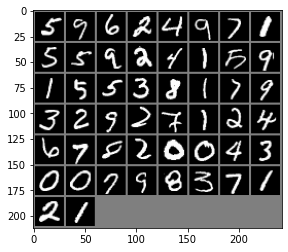

In [9]:
def imshow(img):
    img = torchvision.utils.make_grid(img)
    img = img /2 + 0.5
    nping = img.detach().numpy()
    plt.imshow(np.transpose(nping, (1, 2, 0)))
    plt.show()

iterator = iter(trainloader)
x, _ = next(iterator)
imshow(x)

In [12]:
def train(net, criterion, optimaizer, epochs, trainloader):
    losses = []
    output_and_label = []

    for epoch in range(1, epochs + 1):
        print(f'epoch:{epoch}', end = '')
        runnning_loss = 0.0
        for counter, (img, _) in enumerate(trainloader, 1):
            optimizer.zero_grad()
            img = img.reshape(-1, input_size)
            output = net(img)
            loss = criterion(output, img)
            loss.backward()
            optimaizer.step()
            runnning_loss += loss.item()
        avg_loss = runnning_loss / counter
        losses.append(avg_loss)
        print('loss:', avg_loss)
        output_and_label.append((output, img))
    print('finished')
    return output_and_label, losses

input_size = 28 * 28
net = AutoEncoder(input_size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.1)
EPOCHS = 10 # 100

output_and_label, losses = train(net, criterion, optimizer, EPOCHS, trainloader)

epoch:1loss: 0.3261249118919174
epoch:2loss: 0.24628723667313654
epoch:3loss: 0.24207107813407977
epoch:4loss: 0.23441932080934444
epoch:5loss: 0.22140223003923892
epoch:6loss: 0.21778094302862883
epoch:7loss: 0.21427236651380857
epoch:8loss: 0.21063806819419065
epoch:9loss: 0.20719504059602817
epoch:10loss: 0.2040229648972551
finished


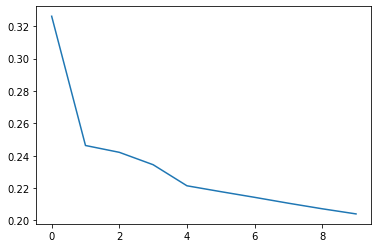

In [13]:
plt.plot(losses)

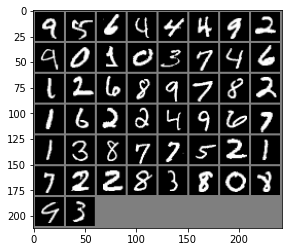

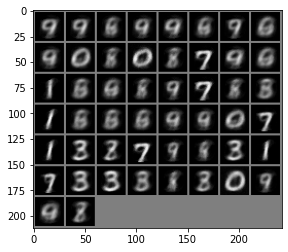

In [14]:
output, org = output_and_label[-1]
imshow(org.reshape(-1, 1, 28, 28))
imshow(output.reshape(-1, 1, 28, 28))

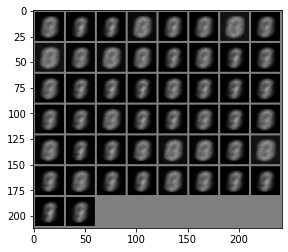

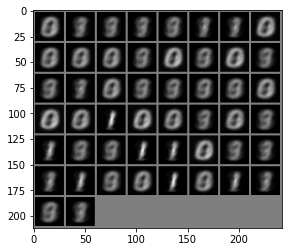

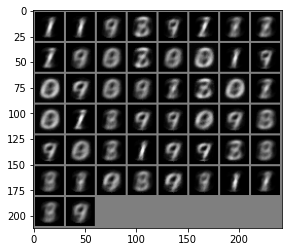

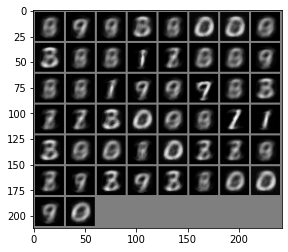

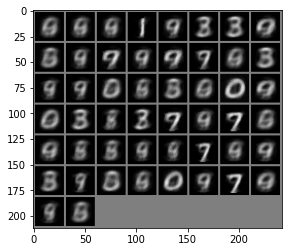

In [15]:
for img, _ in output_and_label[0:10:2]:
    imshow(img.reshape(-1, 1, 28, 28))

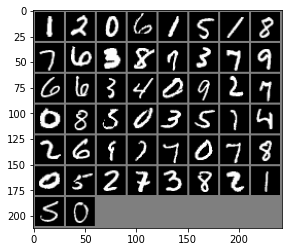

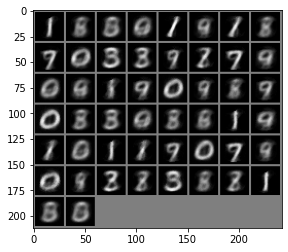

In [18]:
iterator = iter(testloader)
img, _ = next(iterator)
img = img.reshape(-1, 28 *28)
output = net(img)
imshow(img.reshape(-1, 1, 28, 28))
imshow(output.reshape(-1, 1, 28, 28))

In [19]:
sampleloader = DataLoader(testset, batch_size = 1500)
iterator = iter(sampleloader)
img, label = next(iterator)
z = net.enc(img.reshape(-1, 28*28))
z = z.detach().numpy() # 後から簡単に使えるようにするための処理
print(z.shape) # (1500, 2)

(1500, 2)


In [22]:
set_list = [set() for x in range(10)]
for coord, lbl in zip(z.tolist(), label):
    set_list[lbl].add(tuple(coord))

In [23]:
for idx in range(10):
    print(f'items in set_list[{idx}]:')
    for cnt, item in enumerate(set_list[idx]):
        print(item)
        if cnt > 5:
            break

items in set_list[0]:
(-1.431877613067627, 2.06286883354187)
(-1.2539758682250977, 2.8789875507354736)
(-1.706708312034607, 2.757370948791504)
(-1.2297143936157227, 2.6219825744628906)
(-2.33701753616333, 0.9245724678039551)
(-1.171649694442749, 2.5170416831970215)
(-1.4328844547271729, 2.8111348152160645)
items in set_list[1]:
(-15.202937126159668, 23.715118408203125)
(-15.486488342285156, 23.476835250854492)
(-15.178901672363281, 23.56682777404785)
(-14.351710319519043, 20.378923416137695)
(-4.605100154876709, 10.269876480102539)
(-13.4518404006958, 24.28400993347168)
(-13.680866241455078, 24.503835678100586)
items in set_list[2]:
(-4.09198522567749, 5.976242542266846)
(-1.1031382083892822, 8.664039611816406)
(-3.523834705352783, 8.175084114074707)
(-3.174215078353882, 8.623743057250977)
(-3.006183385848999, 8.743680953979492)
(-1.0601011514663696, 5.208712100982666)
(-1.3208969831466675, 5.322238445281982)
items in set_list[3]:
(-1.8564469814300537, 5.121665000915527)
(-1.5437647104

['0: r', '1: g', '2: b', '3: c', '4: k', '5: y', '6: orange', '7: lightgreen', '8: hotpink', '9: yellow']


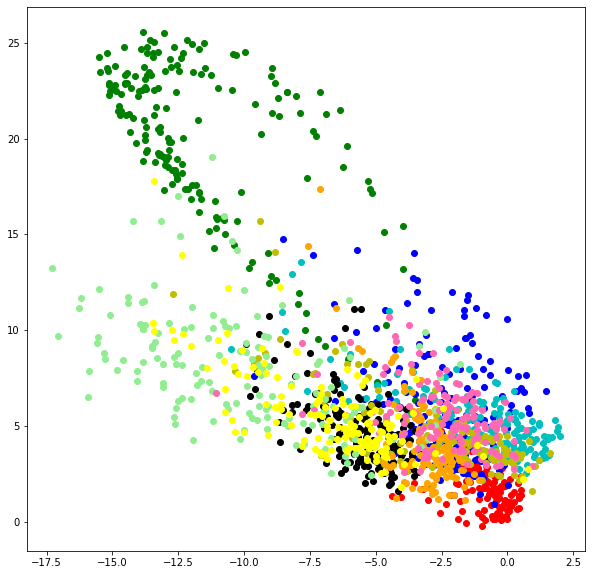

In [25]:
colorlist = ["r", "g", "b", "c", "k", "y", "orange", "lightgreen", "hotpink", "yellow"]
plt.figure(figsize=(10, 10))
for idx in range(10):
    for x, y in set_list[idx]:
        plt.scatter(x, y, c=colorlist[idx])
description = [f"{idx}: {colorlist[idx]}" for idx in range(10)]
print(description)